This particular version is based on cesm_stab_functions_CAM_iter_array_math.ncl from Rich (located here:  /glade/u/home/rneale/ncl/cesm2/lab_sea/). 
<br><br>
The first section attempts to use a modified version of that NCL script (/glade/work/mdfowler/gust_cam7/Analysis/cesm_stab_functions_CAM_iter_array_math_v2.ncl), but noticed that the computed u10n is *not* the same as U10 as output from the history fields. So now the question is - why?? 
<br> <br>
The second section thus tries to re-create the shr_flux_mod routine that computes u10n here in python. 

In [1]:
# Load libraries

# Analysis
import datetime
import glob
import os
import warnings
from datetime import date, timedelta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib.colors as colors
# Plotting utils 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.util import add_cyclic_point
import seaborn as sns

warnings.filterwarnings('ignore')

## Section 1: Can we just adapt Rich's existing NCL script for these runs?

In [2]:
# testFile32 = '/glade/work/mdfowler/gust_cam7/Analysis/F2010climo.f09_f09_mg17.TestGustGlobal_Control_32Lcam6_branch.002.stabilityInfo.nc'
testFile32 = '/glade/work/mdfowler/gust_cam7/Analysis/F2010climo.f09_f09_mg17.TestGustGlobal_Control_32Lcam6_branch.003.stabilityInfo.nc'
testFile58 = '/glade/work/mdfowler/gust_cam7/Analysis/F2010climo.f09_f09_mg17.TestGustGlobal_Control_58Lcam6_branch.003.stabilityInfo.nc'

L32ds = xr.open_dataset(testFile32, decode_times=True)
L58ds = xr.open_dataset(testFile58, decode_times=True)

origFile32 = '/glade/work/mdfowler/gust_cam7/output/F2010climo.f09_f09_mg17.TestGustGlobal_Control_32Lcam6_branch.003.cam.h1.0004-01-01-10800.nc'
origFile58 = '/glade/work/mdfowler/gust_cam7/output/F2010climo.f09_f09_mg17.TestGustGlobal_Control_58Lcam6_branch.003.cam.h1.0004-01-01-10800.nc'

origDS_32 = xr.open_dataset(origFile32, decode_times=True)
origDS_58 = xr.open_dataset(origFile58, decode_times=True)


startTime = 16    ## Discard the first two days 
nTimes    = len(L32ds.time.values)-1

print('Start time (raw) : ',origDS_32.time.values[0]) 
print('End time (raw)   : ',origDS_32.time.values[nTimes]) 

L32ds = L32ds.isel(time=np.arange(startTime,nTimes,1))
L58ds = L58ds.isel(time=np.arange(startTime,nTimes,1))
origDS_32 = origDS_32.isel(time=np.arange(startTime,nTimes,1))
origDS_58 = origDS_58.isel(time=np.arange(startTime,nTimes,1))

print('Start time (used) : ',origDS_32.time.values[0]) 
print('End time (used)   : ',origDS_32.time.values[-1])

Start time (raw) :  0004-01-01 03:00:00
End time (raw)   :  0004-01-15 00:00:00
Start time (used) :  0004-01-03 03:00:00
End time (used)   :  0004-01-14 21:00:00


In [3]:
# origDS_32['windBot'] = (('time','lat','lon'), np.sqrt(origDS_32.UBOT.values**2 + origDS_32.VBOT.values**2))
# origDS_58['windBot'] = (('time','lat','lon'), np.sqrt(origDS_58.UBOT.values**2 + origDS_58.VBOT.values**2))

origDS_32['windBot'] = (('time','lat','lon'), np.sqrt(origDS_32.UBOT.values**2 + origDS_32.VBOT.values**2 ))
origDS_58['windBot'] = (('time','lat','lon'), np.sqrt(origDS_58.UBOT.values**2 + origDS_58.VBOT.values**2 ))

L32ds['rd_ov_rdn'] = (('time','lat','lon'), L32ds['rd'].values/L32ds['rdn'].values)
L58ds['rd_ov_rdn'] = (('time','lat','lon'), L58ds['rd'].values/L58ds['rdn'].values)



In [4]:
## Also read in ocean frac:
dataDir = '/glade/work/mdfowler/gust_cam7/output/'

h0File    = dataDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h0.0002-01.nc'
ofrac32      = xr.open_dataset(h0File, decode_times=True).isel(time=0)['OCNFRAC']
ocnMask32             = np.ones([len(L32ds.lat.values),len(L32ds.lon.values)])
ocnMask32[ofrac32==0] = np.nan

h0File58    = dataDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.001.cam.h0.0002-01.nc'
ofrac58     = xr.open_dataset(h0File58, decode_times=True).isel(time=0)['OCNFRAC']
ocnMask58             = np.ones([len(L58ds.lat.values),len(L58ds.lon.values)])
ocnMask58[ofrac58==0] = np.nan



First order question: Does U10 = u10n?

L32 time:     0004-01-05 18:00:00
orig32 time:  0004-01-05 18:00:00


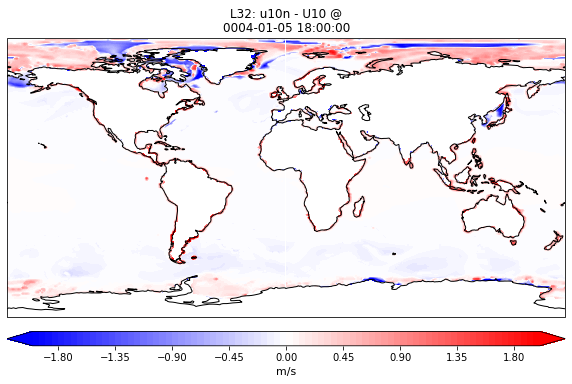

In [43]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 21

cplot = axs.contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L32ds['u10n'].values[timeSel,:,:] - origDS_32['U10'].values[timeSel,:,:]), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L32: u10n - U10 @\n'+str(origDS_32.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)

print('L32 time:    ', L32ds.time.values[timeSel])
print('orig32 time: ', origDS_32.time.values[timeSel])



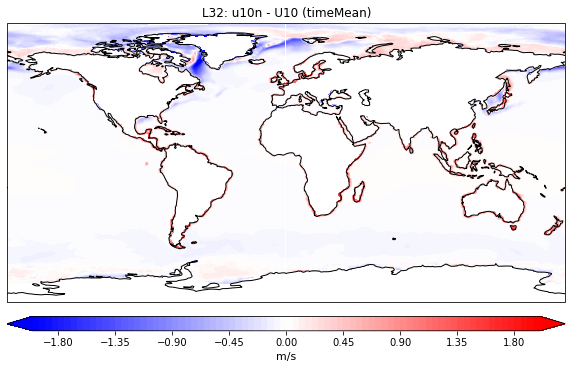

In [13]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L32ds['u10n'].mean(dim='time').values - origDS_32['U10'].mean(dim='time').values), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L32: u10n - U10 (timeMean)',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)



L58 time:     0004-01-05 18:00:00
orig58 time:  0004-01-05 18:00:00


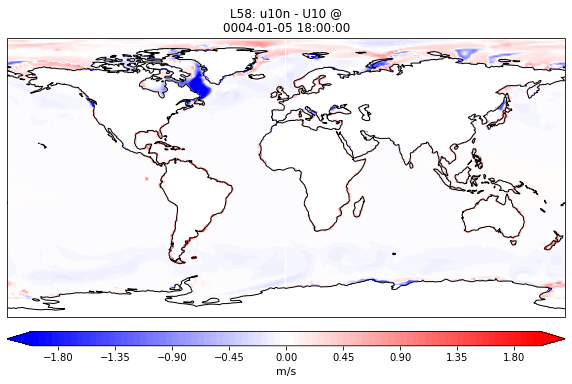

In [45]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 21

cplot = axs.contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(L58ds['u10n'].values[timeSel,:,:] - origDS_58['U10'].values[timeSel,:,:]), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58: u10n - U10 @\n'+str(origDS_58.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)

print('L58 time:    ', L58ds.time.values[timeSel])
print('orig58 time: ', origDS_58.time.values[timeSel])



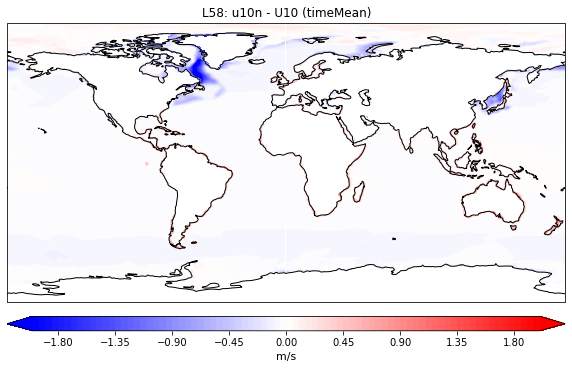

In [5]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(L58ds['u10n'].mean(dim='time').values - origDS_58['U10'].mean(dim='time').values), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title('L58: u10n - U10 (timeMean)',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)





Weird that these things don't line up... <br>
At least in the history file then, what's the relationship between windBot and U10?

Text(0.5, 1.0, 'windBot - U10')

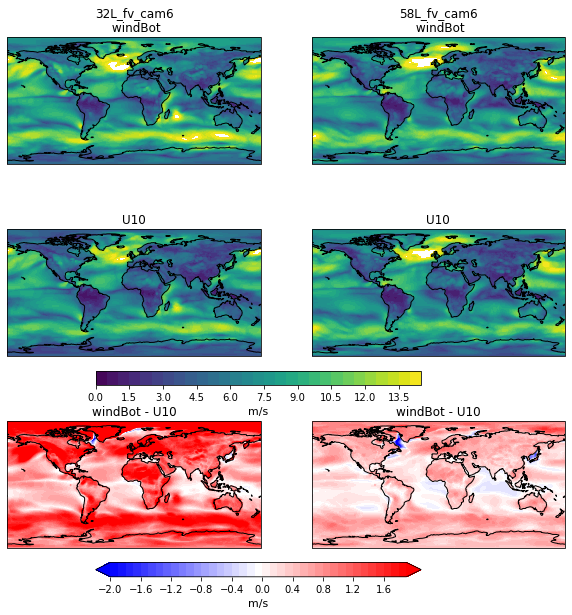

In [6]:
## Set up figure 
fig,axs = plt.subplots(3,2, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

ubotLevs = np.arange(0,15, 0.5) 

axs[0].contourf(origDS_32.lon.values, origDS_32.lat.values, 
                np.squeeze(origDS_32['windBot'].mean(dim='time').values), ubotLevs)

axs[1].contourf(origDS_58.lon.values, origDS_58.lat.values, 
                np.squeeze(origDS_58['windBot'].mean(dim='time').values), ubotLevs)


axs[2].contourf(origDS_32.lon.values, origDS_32.lat.values, 
                np.squeeze(origDS_32['U10'].mean(dim='time').values), ubotLevs)

c3 = axs[3].contourf(origDS_58.lon.values, origDS_58.lat.values, 
                np.squeeze(origDS_58['U10'].mean(dim='time').values), ubotLevs)
## Add colorbar
ax_position = axs[3].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.1, 0.02])
cbar        = plt.colorbar(c3, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)
    
    
    
diffLevs = np.arange(-2.0,2.0,0.1)
axs[4].contourf(L32ds.lon.values, L32ds.lat.values, 
                np.squeeze(origDS_32['windBot'].mean(dim='time').values - origDS_32['U10'].mean(dim='time').values), 
                diffLevs,cmap='bwr',extend='both')

c5 = axs[5].contourf(L58ds.lon.values, L58ds.lat.values, 
                np.squeeze(origDS_58['windBot'].mean(dim='time').values - origDS_58['U10'].mean(dim='time').values), 
                diffLevs,cmap='bwr',extend='both')

## Add colorbar
ax_position = axs[5].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.1, 0.02])
cbar        = plt.colorbar(c5, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)

axs[0].coastlines()
axs[1].coastlines()
axs[2].coastlines()
axs[3].coastlines()
axs[4].coastlines()
axs[5].coastlines()

axs[0].set_title('32L_fv_cam6\n windBot')
axs[1].set_title('58L_fv_cam6\n windBot')
axs[2].set_title('U10')
axs[3].set_title('U10')
axs[4].set_title('windBot - U10')
axs[5].set_title('windBot - U10')

In [41]:
nTimes = len(L32ds.time.values)

countGridCells = np.full([nTimes], np.nan)

for iT in range(nTimes):
    diff_L32 = np.squeeze(origDS_32['windBot'].values[iT,:,:] - origDS_32['U10'].values[iT,:,:])*ocnMask32
    
    countGridCells[iT] = len(np.where(diff_L32<0)[0])
    
iMax = np.where(countGridCells==np.nanmax(countGridCells))[0]
print('Index of with most frequent occurence of windBot < U10: ', iMax)

Index of with most frequent occurence of windBot < U10:  [21]


Text(0.5, 1.0, 'windBot - U10')

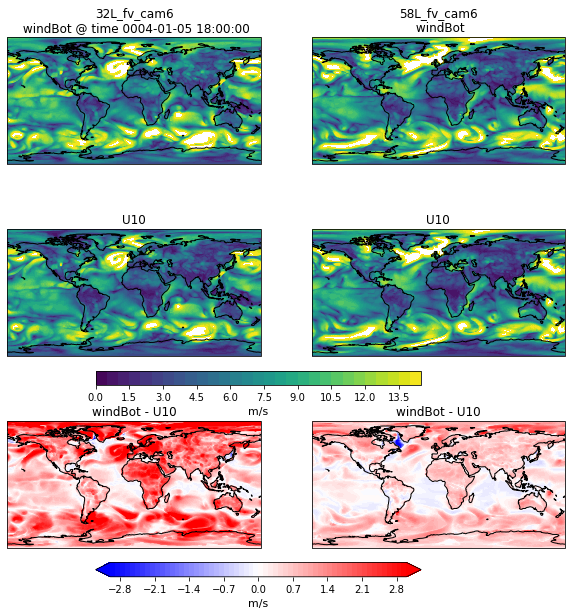

In [42]:
## Set up figure 
fig,axs = plt.subplots(3,2, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

ubotLevs = np.arange(0,15, 0.5) 

timeSel  = 21

axs[0].contourf(origDS_32.lon.values, origDS_32.lat.values, 
                np.squeeze(origDS_32['windBot'].values[timeSel,:,:]), ubotLevs)

axs[1].contourf(origDS_58.lon.values, origDS_58.lat.values, 
                np.squeeze(origDS_58['windBot'].values[timeSel,:,:]), ubotLevs)


axs[2].contourf(origDS_32.lon.values, origDS_32.lat.values, 
                np.squeeze(origDS_32['U10'].values[timeSel,:,:]), ubotLevs)

c3 = axs[3].contourf(origDS_58.lon.values, origDS_58.lat.values, 
                np.squeeze(origDS_58['U10'].values[timeSel,:,:]), ubotLevs)
## Add colorbar
ax_position = axs[3].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.1, 0.02])
cbar        = plt.colorbar(c3, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)
    
    
    
diffLevs = np.arange(-3,3.1,0.1)
axs[4].contourf(L32ds.lon.values, L32ds.lat.values, 
                np.squeeze(origDS_32['windBot'].values[timeSel,:,:] - origDS_32['U10'].values[timeSel,:,:]), diffLevs,cmap='bwr',extend='both')

c5 = axs[5].contourf(L58ds.lon.values, L58ds.lat.values, 
                np.squeeze(origDS_58['windBot'].values[timeSel,:,:] - origDS_58['U10'].values[timeSel,:,:]), diffLevs,cmap='bwr',extend='both')

## Add colorbar
ax_position = axs[5].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.1, 0.02])
cbar        = plt.colorbar(c5, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)

axs[0].coastlines()
axs[1].coastlines()
axs[2].coastlines()
axs[3].coastlines()
axs[4].coastlines()
axs[5].coastlines()

axs[0].set_title('32L_fv_cam6\n windBot @ time '+str(origDS_58.time.values[timeSel]))
axs[1].set_title('58L_fv_cam6\n windBot')
axs[2].set_title('U10')
axs[3].set_title('U10')
axs[4].set_title('windBot - U10')
axs[5].set_title('windBot - U10')



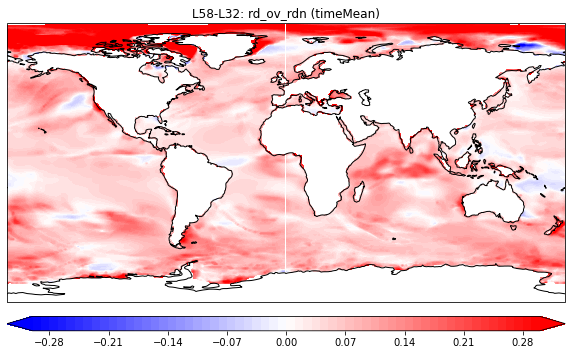

In [8]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

varPlot = 'rd_ov_rdn'

cplot = axs.contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L58ds[varPlot].mean(dim='time').values - L32ds[varPlot].mean(dim='time').values), 
                        np.arange(-0.3,0.31,0.01), cmap='bwr', extend='both')

axs.set_title('L58-L32: '+varPlot+' (timeMean)',fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# print('L32 time:    ', L32ds.time.values[timeSel])
# print('orig32 time: ', origDS_32.time.values[timeSel])



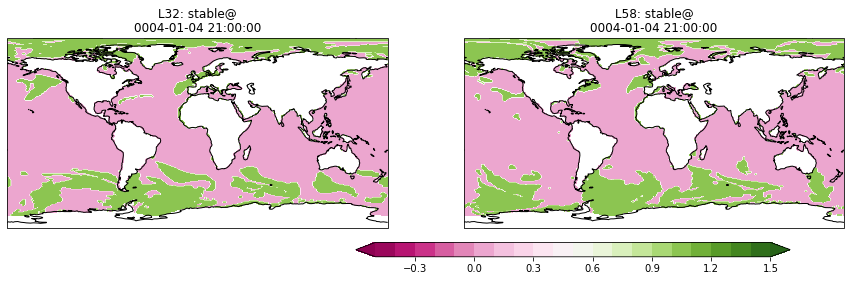

In [11]:
fig,axs = plt.subplots(1,2, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs.ravel()

timeSel = 21

cplot = axs[0].contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L32ds['stable'].values[timeSel,:,:]), np.arange(-0.5, 1.6, 0.1), cmap='PiYG', extend='both')

axs[0].set_title('L32: stable@\n'+str(L32ds.time.values[timeSel]),fontsize=12)
axs[0].coastlines()

cplot = axs[1].contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(L58ds['stable'].values[timeSel,:,:]), np.arange(-0.5, 1.6, 0.1), cmap='PiYG', extend='both')

axs[1].set_title('L58: stable@\n'+str(L58ds.time.values[timeSel]),fontsize=12)
axs[1].coastlines()

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.05, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# print('L32 time:    ', L32ds.time.values[timeSel])
# print('orig32 time: ', origDS_32.time.values[timeSel])



(array([3141360., 1073312.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

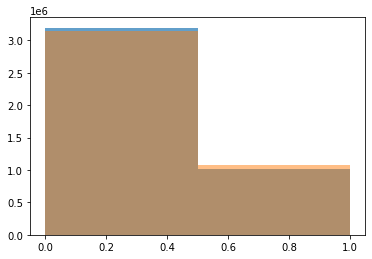

In [18]:
distVar = 'stable'
# Define dataframe
l32var = np.squeeze(L32ds[distVar].values*ocnMask32).reshape([len(L32ds.lon.values)*len(L32ds.lat.values)*len(L32ds.time.values)])
l58var =  np.squeeze(L58ds[distVar].values*ocnMask58).reshape([len(L32ds.lon.values)*len(L32ds.lat.values)*len(L32ds.time.values)])

plt.hist(l32var, bins=2, alpha=0.7, label='L32')
plt.hist(l58var, bins=2, alpha=0.5, label='L58')




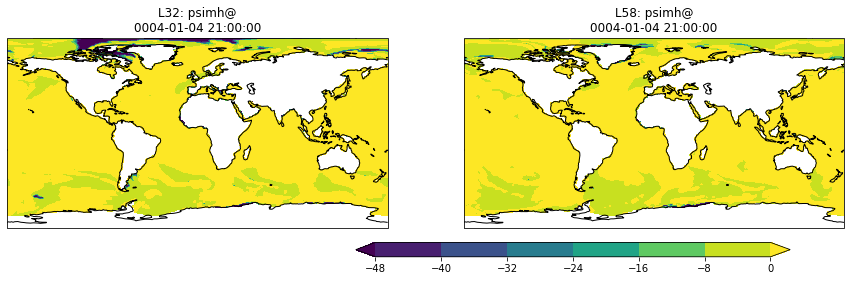

In [19]:
fig,axs = plt.subplots(1,2, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs.ravel()

timeSel = 21

cplot = axs[0].contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L32ds['psimh'].values[timeSel,:,:]), extend='both')

axs[0].set_title('L32: psimh@\n'+str(L32ds.time.values[timeSel]),fontsize=12)
axs[0].coastlines()

cplot = axs[1].contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(L58ds['psimh'].values[timeSel,:,:]), extend='both')

axs[1].set_title('L58: psimh@\n'+str(L58ds.time.values[timeSel]),fontsize=12)
axs[1].coastlines()

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.05, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# print('L32 time:    ', L32ds.time.values[timeSel])
# print('orig32 time: ', origDS_32.time.values[timeSel])



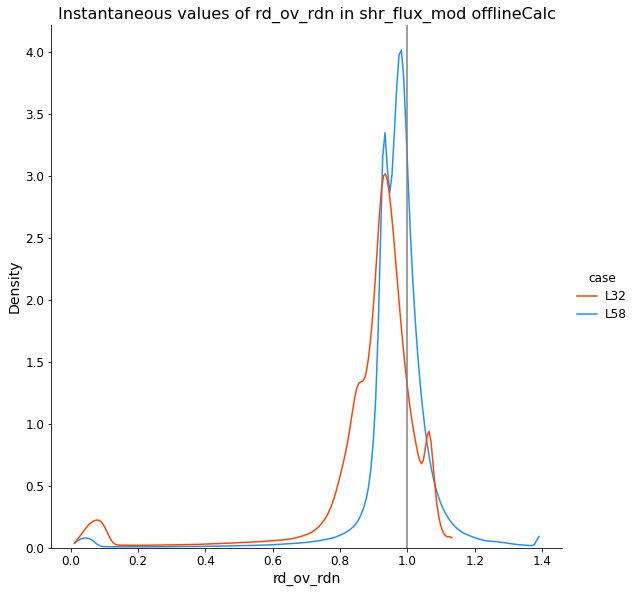

In [10]:
distVar = 'rd_ov_rdn'

# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({distVar: np.squeeze(L32ds[distVar].values*ocnMask32).reshape([len(L32ds.lon.values)*len(L32ds.lat.values)*len(L32ds.time.values)]), 'case': 'L32'}),
     pd.DataFrame.from_dict({distVar: np.squeeze(L58ds[distVar].values*ocnMask58).reshape([len(L32ds.lon.values)*len(L32ds.lat.values)*len(L32ds.time.values)]), 'case': 'L58'}),
 ])

# Make plot 
g = sns.displot(dfReal, x=distVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['orangered','dodgerblue'])


g.ax.set_title("Instantaneous values of "+distVar+" in shr_flux_mod offlineCalc", fontsize=16 ) 
g.ax.set_xlabel(distVar,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)

g.ax.axvline(1, color='grey')



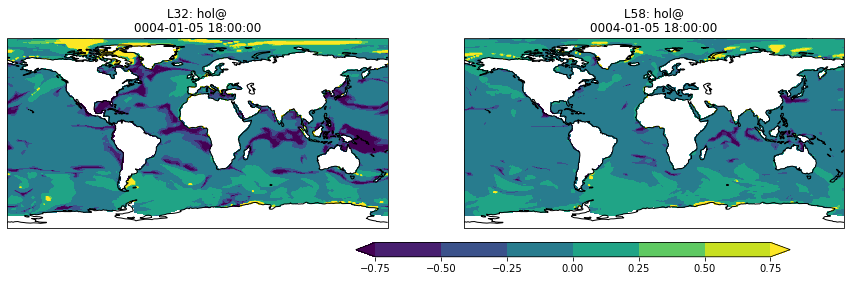

In [18]:
fig,axs = plt.subplots(1,2, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs.ravel()

timeSel = 21

cplot = axs[0].contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L32ds['hol'].values[timeSel,:,:]), extend='both')

axs[0].set_title('L32: hol@\n'+str(L32ds.time.values[timeSel]),fontsize=12)
axs[0].coastlines()

cplot = axs[1].contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(L58ds['hol'].values[timeSel,:,:]), extend='both')

axs[1].set_title('L58: hol@\n'+str(L58ds.time.values[timeSel]),fontsize=12)
axs[1].coastlines()

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.05, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# print('L32 time:    ', L32ds.time.values[timeSel])
# print('orig32 time: ', origDS_32.time.values[timeSel])



In [ ]:
fig,axs = plt.subplots(1,2, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs.ravel()

timeSel = 21

cplot = axs[0].contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L32ds['rd_ov_rdn'].values[timeSel,:,:]), np.arange(0.9,1.11,0.01), cmap='PRGn', extend='both')

axs[0].set_title('L32: rd_ov_rdn@\n'+str(L32ds.time.values[timeSel]),fontsize=12)
axs[0].coastlines()

cplot = axs[1].contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(L58ds['rd_ov_rdn'].values[timeSel,:,:]), np.arange(0.9,1.11,0.01), cmap='PRGn',extend='both')

axs[1].set_title('L58: rd_ov_rdn@\n'+str(L58ds.time.values[timeSel]),fontsize=12)
axs[1].coastlines()

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.05, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# print('L32 time:    ', L32ds.time.values[timeSel])
# print('orig32 time: ', origDS_32.time.values[timeSel])



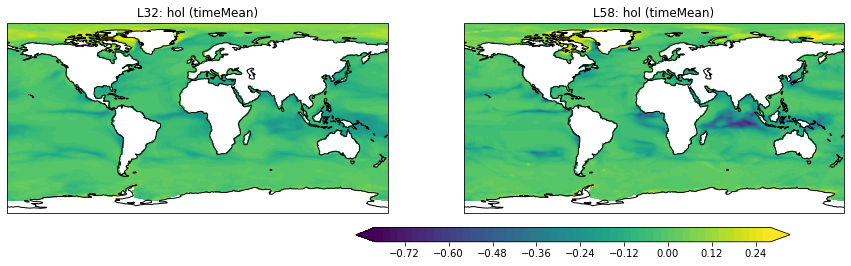

In [15]:
fig,axs = plt.subplots(1,2, figsize=(15,10), subplot_kw={'projection':ccrs.PlateCarree()})
axs.ravel()

#pltVar = 'rd_ov_rdn'   # np.arange(0.9,1.11,0.01)
pltVar = 'hol' 

cplot = axs[0].contourf(L32ds.lon.values, L32ds.lat.values, 
            ocnMask32*np.squeeze(L32ds[pltVar].mean(dim='time').values), np.arange(-0.8,0.3,0.02), cmap='viridis', extend='both')

axs[0].set_title('L32: '+pltVar+' (timeMean)',fontsize=12)
axs[0].coastlines()

cplot = axs[1].contourf(L58ds.lon.values, L58ds.lat.values, 
            ocnMask58*np.squeeze(L58ds[pltVar].mean(dim='time').values), np.arange(-0.8,0.3,0.02), cmap='viridis',extend='both')

axs[1].set_title('L58: '+pltVar+' (timeMean)',fontsize=12)
axs[1].coastlines()

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.04, ax_position.width+0.05, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# print('L32 time:    ', L32ds.time.values[timeSel])
# print('orig32 time: ', origDS_32.time.values[timeSel])



## Section 2: Try to recreate function in python

In [34]:
dataDir    = '/glade/work/mdfowler/gust_cam7/output/'
scratchDir = '/glade/scratch/mdfowler/archive/'

caseNames  = [
              'F2010climo.f09_f09_mg17.TestGustGlobal_Control_32Lcam6_branch.003', 
              # 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58Lcam6_branch.003'
              ]
caseLabels = [
             'L32_fv_cam6', 
             # 'L58_fv_cam6'
            ]


for iCase in range(len(caseNames)): 
    
    listFiles = np.sort(glob.glob(dataDir+caseNames[iCase]+'*cam.h1*'))
    if len(listFiles)>1:
        print('WARNING: more than one matching file found; using first file in list') 
    print(listFiles)
        
    ## Open dataset and give it a meaningful label
    ds = xr.open_dataset(listFiles[0], decode_times=True)
    ds = ds.assign_coords({"case": caseLabels[iCase]})
    
    ## Combine everything into a single DS (hope this works) 
    if iCase==0: 
        caseDS = ds 
    else: 
        caseDS = xr.concat([caseDS, ds], "case")

    print('Done loading data for case %s' % caseLabels[iCase])
    
    
## Also read in ocean frac:
if caseLabels[0]=='L32_fv_cam6':
    h0File    = dataDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h0.0002-01.nc'
    ofrac     = xr.open_dataset(h0File, decode_times=True).isel(time=0)['OCNFRAC']
elif caseLabels[0]=='L58_fv_cam6':
    h0File    = dataDir+'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.001.cam.h0.0002-01.nc'
    ofrac     = xr.open_dataset(h0File, decode_times=True).isel(time=0)['OCNFRAC']
    
    

['/glade/work/mdfowler/gust_cam7/output/F2010climo.f09_f09_mg17.TestGustGlobal_Control_32Lcam6_branch.003.cam.h1.0004-01-01-10800.nc']
Done loading data for case L32_fv_cam6


In [35]:
## Pull out into arrays (matches NCL script more directly, for better or worse) 
tbot = caseDS['TBOT'].values 
ts   = caseDS['TS'].values 
ubot = caseDS['UBOT'].values 
vbot = caseDS['VBOT'].values 
qbot = caseDS['QBOT'].values
# zbot = caseDS['ZBOT'].values 
thbot = caseDS['THBOT'].values
rbot  = caseDS['RBOT'].values 
# pbot  = caseDS['PBOT'].values

lat      = caseDS['lat'].values
lon      = caseDS['lon'].values
time     = caseDS['time'].values
date     = caseDS['date'].values

nlats    = len(lat)
nlons    = len(lon)
ntime    = len(time)

ocnMask = np.ones([nlats,nlons])
ocnMask[ofrac==0] = 0 

fmiss = 1.0e36

In [36]:
## Copying vars from NCL script (confirm that the set up is the same in current CAM version?)
SHR_CONST_RDAIR   = (6.02214e26*1.38065e-23)/28.966
SHR_CONST_RWV     = (6.02214e26*1.38065e-23)/18.016

loc_zvir = (SHR_CONST_RWV/SHR_CONST_RDAIR)-1

loc_karman = 0.4
# loc_cpvir = 1.81e3/1.00464e3 - 1   #MDF: Mising -1? 
loc_cpvir = 1.81e3/1.00464e3
loc_cpdair = 1.00464e3

loc_g      = 9.80616
loc_latvap = 2.501e6  # LH f evap.
loc_stebol = 5.67e-8  # SB constant.

zref  = 10.  # Ref height for U
ztref = 2.   # Ref height for T

## Change this!! 
zbot = 66.  # Lowest model level.
# zbot = zbot
print('Mean value of zbot: ', np.nanmean(zbot))

umin         = 0.5   # Floor for vmag.
ocn_frac_lim = 0.01  # Ofrac has to be greater than this for calcs.

al2 = np.log(zref/ztref)

## Updated definition of pbot to be automated
pbot = caseDS.isel(lev=-1).lev.values # PBOT (mb)
print('Value of pbot: ',pbot) 

vmagx_loop = 0 # Standard vmag used in calculation.
hol_lim0   = 10. # Stab and instab limiter on hol

# niter = 2          # Num of implicit iterations.
thresh_pcent = 0.1  # Convergence criteria

pnon_conv = 0       # Non-converging point counter

Mean value of zbot:  66.0
Value of pbot:  992.556095123291


In [37]:
# ## Set up arrays 
# nconv_iter = 0*(tbot_loop.astype('int'))

# imiss      =  default_fillvalue(typeof(nconv_iter))

# nconv_iter = default_fillvalue(typeof(nconv_iter))

# flux_conv = new((/niter+1,ntime,nlats,nlons/),"float")

# # ;;;;;;;;;;;;;;; ARRAY LOOPS ;;;;;;;;;;;;;;;;;

# nloops = dimsizes(ts_loop)

In [38]:
# ts   = ts_loop    # TS (SST)
# tbot = tbot_loop  # TBOT
# ubot = ubot_loop  # UBOT
# vbot = vbot_loop  # VBOT

# print("-Assign up front info")

# ## Derived values that we don't have: 
# pbot = pbot*100

# thbot = tbot*(1000.0/pbot)**0.286   # THBOT (pot. temp) form from ncl.   ## MDF: I think this is supposed to be p0/pbot, not pbot/p0 
# thbot = tbot*(pbot/1000.)**0.286   # THBOT (pot. temp) form from ncl.
# --- The calculation for thbot in the coupler is :
# aoflux_in%thbot(n) = aoflux_in%tbot(n)*((100000._R8/aoflux_in%pbot(n))**0.286_R8)
# thbot = tbot*((100000/pbot)**0.286)

# rbot  = pbot/(8.314e3*tbot)   # Air density - pbot/(Rsp*T_bot)
# --- The calculation for rbot in the coupler is:
# aoflux_in%dens(n) = aoflux_in%pbot(n)/(287.058_R8*(1._R8 + 0.608_R8*aoflux_in%shum(n))*aoflux_in%tbot(n))
# rbot = pbot/(287.058*(1.0 + 0.608*qbot)*tbot)

#     Ultimately: rbot is computed as in the first line if it's passed from the atm to the coupler. 
#       It's computed *by* the coupler if not available from the atm following the second formulation. I'm going to 
#       assume that it is provided by the atm... Looks like it's passed as 'Sa_dens' 

# qsat = 640380.0 / exp(5107.4/ts)
qsat  = 640380.0 / np.e**(5107.4/ts)

#          vmag0 = max((/umin, sqrt(ubot^2+vbot^2)/))
#          vmag0 = where(sqrt(ubot**2+vbot**2).gt.umin,sqrt(ubot**2+vbot**2),umin)
vmag             = np.sqrt(ubot**2 + vbot**2) 
vmag[vmag<umin]  = umin

ssq  = 0.98 * qsat / rbot
delt = thbot - ts
delq = qbot - ssq
alz  = np.log(zbot/zref)
cp   = loc_cpdair*(1.0 + loc_cpvir*ssq)
#hol_limit = hol_lim0+ts*0.


In [39]:
###  Mahrt and Sun (1995) ;;;
# Cold Air Outbreak Modification:
# Increase windspeed for negative tbot-ts
tdiff = tbot - ts 

alpha  = 1.4 
maxscl = 2.0   # maximum wind scaling for flux
td0    = -10.0  # start t-ts for scaling

use_coldair_outbreak_mod = False

if use_coldair_outbreak_mod==True: 
    for iT in range(ntime): 
        for iLat in range(nlats):
            for iLon in range(nlons):
                if tdiff[iT,iLat,iLon] < td0: 
                    valCheck = 1.0+alpha*(np.abs(tdiff[iT,iLat,iLon]-td0)**0.5/np.abs(vmag[iT,iLat,iLon]))
                    if valCheck > maxscl: 
                        valCheck = maxscl 
                    vmag[iT,iLat,iLon] = vmag[iT,iLat,iLon]*valCheck
    
    
#     # vscl     = np.ones([ntime, nlats, nlons])
#     vscl            = np.copy(tdiff)
#     vscl[vscl>=td0] = 1.0
#     # vscl[:,:,:] = 1.0
    
#     valCheck = 1.0+alpha*(np.abs(tdiff-td0)**0.5/np.abs(vmag))
#     valCheck[valCheck>maxscl] = maxscl
    
#     vscl[vscl < td0] = valCheck[vscl<td0]
    
#     vmag = vmag*vscl
    
# ## cold air outbreak code:
# if (tdiff(n).lt.td0) then
#    vscl=min((1._R8+alpha*(abs(tdiff(n)-td0)**0.5_R8/abs(vmag))),maxscl)
#    vmag=vmag*vscl
# endif

In [40]:
# Z/L ustar, tstar first estimates

# stable = 0.5 + sign_f90(delt*0.+0.5 , delt) # Basically routines 0.5 with the sign of delt.
stable = 0.5 + (np.sign(delt)*0.5) # Basically routines 0.5 with the sign of delt.

def get_cdn(wind): 
    cdn    = 0.0027 / wind + 0.000142 + 0.0000764 * wind
    return cdn 


# cdn    = 0.0027 / vmag + 0.000142 + 0.0000764 * vmag # Neutral drag coeff at lowest model layer wind value.
# cdn    = get_cdn(vmag)
rdn    = np.sqrt(get_cdn(vmag))  # sqrtt of neutral exchange coeff (momomentum)

# Neutral exchange coeff (iff stable=0.0327, unstable=0.018)
rhn    = (1.0-stable) * 0.0327 + stable * 0.018 # sqrtt of neutral exchange coeff (heat)
ren    = 0.0346 # Water.

# !--- ustar, tstar, qstar ---
ustar = rdn * vmag
tstar = rhn * delt
qstar = ren * delq

ustar_prev = ustar*2.0

In [41]:

flux_con_max_iter = 5 
flux_con_tol      = 0.0

iter = 0 
# while ((np.abs((ustar - ustar_prev)/ustar) > flux_con_tol) & (iter < flux_con_max_iter)):
while ((iter < flux_con_max_iter)):
    iter = iter+1 
    ustar_prev = ustar 
    
    #!--- compute stability & evaluate all stability functions ---
    hol  = loc_karman*loc_g*zbot*(tstar/thbot + qstar/(1.0/loc_zvir+qbot))/ustar**2
    
    # hol  = sign( min(abs(hol),10.0_R8), hol )
    temp_hol = np.abs(hol)
    temp_hol[temp_hol>10.0] = 10.0
    hol  = np.sign(hol)*(temp_hol)
    
    stable = 0.5 + (np.sign(hol)*0.5)

    # xsq    = max(sqrt(abs(1.0_R8 - 16.0_R8*hol)) , 1.0_R8)
    xsq  = np.sqrt(np.abs(1.0 - 16.0*hol))
    xsq[xsq<1.0] = 1.0
    
    xqq = np.sqrt(xsq)
    
    psimhu = np.log((1.0+xqq*(2.0+xqq))*(1.0+xqq*xqq)/8.0) - 2.0*np.arctan(xqq) + 1.571
    psixhu = 2.0 * np.log((1.0 + xqq*xqq)/2.0)
    
    psimh = -5.0*hol*stable + (1.0-stable)*psimhu
    psixh = -5.0*hol*stable + (1.0-stable)*psixhu
    
    #!--- shift wind speed using old coefficient ---
    maxVal = rdn/loc_karman*(alz-psimh)
    maxVal[maxVal < -0.5] = -0.5
    # rd   = rdn / (1.0 + max(rdn/loc_karman*(alz-psimh), -0.5))
    rd   = rdn / (1.0 + maxVal)
    u10n = vmag * rd / rdn
    
    # !--- update transfer coeffs at 10m and neutral stability ---
    #rdn = sqrt(cdn(u10n))
    rdn  = np.sqrt(get_cdn(u10n))
    ren = 0.0346  #cexcd
    rhn = (1.0-stable)*0.0327 + stable * 0.018
    
    
    #!--- shift all coeffs to measurement height and stability ---
    rd = rdn / (1.0 + rdn/loc_karman*(alz-psimh))
    rh = rhn / (1.0 + rhn/loc_karman*(alz-psixh))
    re = ren / (1.0 + ren/loc_karman*(alz-psixh))

    #!--- update ustar, tstar, qstar using updated, shifted coeffs --
    ustar = rd * vmag
    tstar = rh * delt
    qstar = re * delq

In [42]:
#!------------------------------------------------------------
#! compute the fluxes
#!------------------------------------------------------------

tau = rbot * ustar * ustar

#!--- momentum flux ---
us = 0
vs = 0
# taux = tau * (ubot(n)-us(n)) / vmag
# tauy = tau * (vbot(n)-vs(n)) / vmag
taux = tau * (ubot) / vmag
tauy = tau * (vbot) / vmag


#!--- heat flux ---
sen  =          cp * tau * tstar / ustar
lat  =  loc_latvap * tau * qstar / ustar
lwup = -loc_stebol * ts**4

#!--- water flux ---
evap = lat/loc_latvap

In [43]:
# !------------------------------------------------------------
# ! compute diagnositcs: 2m ref T & Q, 10m wind speed squared
# !------------------------------------------------------------
hol = hol*ztref/zbot

# xsq = max( 1.0_R8, sqrt(abs(1.0_R8-16.0_R8*hol)) )
# xqq = sqrt(xsq)
# psix2   = -5.0_R8*hol*stable + (1.0_R8-stable)*psixhu(xqq)
# fac     = (rh/loc_karman) * (alz + al2 - psixh + psix2 )
# tref(n) = thbot(n) - delt*fac
# tref(n) = tref(n) - 0.01_R8*ztref   ! pot temp to temp correction
# fac     = (re/loc_karman) * (alz + al2 - psixh + psix2 )
# qref(n) =  qbot(n) - delq*fac

duu10n = u10n*u10n # 10m wind speed squared

In [44]:
np.sqrt(caseDS.UBOT.values**2 + caseDS.VBOT.values**2)[30,120,120]

4.6519465

In [47]:
u10n[30,120,120]

4.7672663

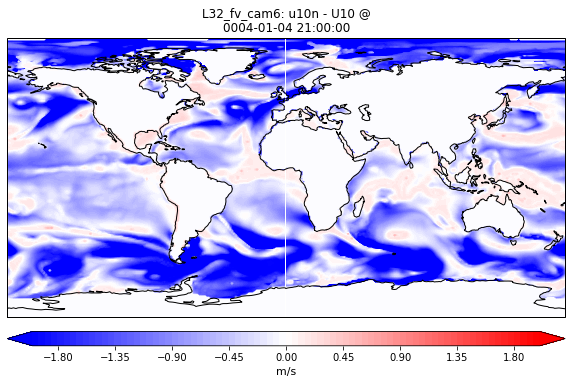

In [48]:
testVal = u10n - np.sqrt(caseDS.UBOT.values**2 + caseDS.VBOT.values**2)

fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 30

cplot = axs.contourf(caseDS.lon.values, caseDS.lat.values, 
            ocnMask*np.squeeze(u10n[timeSel,:,:] - np.sqrt(caseDS.UBOT.values**2 + caseDS.VBOT.values**2)[timeSel,:,:]), np.arange(-2,2.05,0.05), cmap='bwr', extend='both')

axs.set_title(str(caseDS.case.values)+': u10n - U10 @\n'+str(caseDS.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)

# print('L58 time:    ', L58ds.time.values[timeSel])
# print('orig58 time: ', origDS_58.time.values[timeSel])


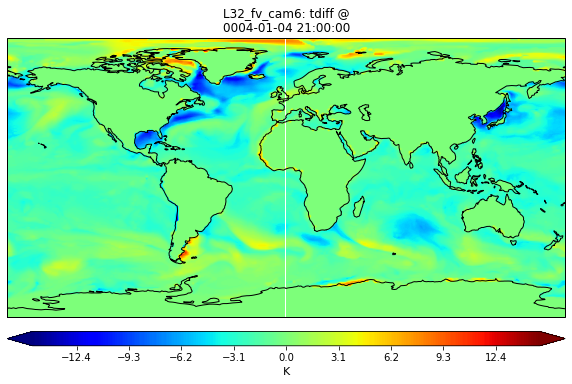

In [14]:
fig,axs = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})

timeSel = 30

cplot = axs.contourf(caseDS.lon.values, caseDS.lat.values, 
            ocnMask*np.squeeze(tdiff[timeSel,:,:]), np.arange(-15,15.1,0.1), cmap='jet', extend='both')

axs.set_title(str(caseDS.case.values)+': tdiff @\n'+str(caseDS.time.values[timeSel]),fontsize=12)
axs.coastlines()

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('K',fontsize=11)